In [1]:
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

In [2]:
observed_angles = np.array([0, -45, -80]) * (2 * np.pi) / 360  # in radians
errors = np.array([10, 10, 10]) * (2 * np.pi) / 360
tower_locations = np.array([[0, 0], [1.1, -0.2], [1.2, 1]])

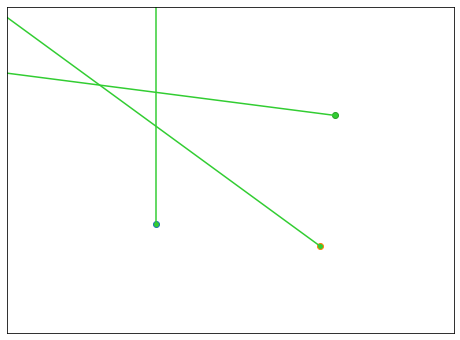

In [3]:
# first plot, just the lines:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(tower_locations.shape[0]):
    r = 4
    ax.plot(tower_locations[i, 0], tower_locations[i, 1], "o", mfc="limegreen")
    ax.plot(
        [tower_locations[i, 0], tower_locations[i, 0] +
            np.sin(observed_angles[i]) * r],
        [tower_locations[i, 1], tower_locations[i, 1] +
            np.cos(observed_angles[i]) * r],
        "-",
        color="limegreen",
    )

xc = np.linspace(-1, 2, 500)
yc = np.linspace(-1, 2, 500)
ax.set_xlim([xc[0], xc[-1]])
ax.set_ylim([yc[0], yc[-1]])
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelleft=False,
    labelbottom=False,
)

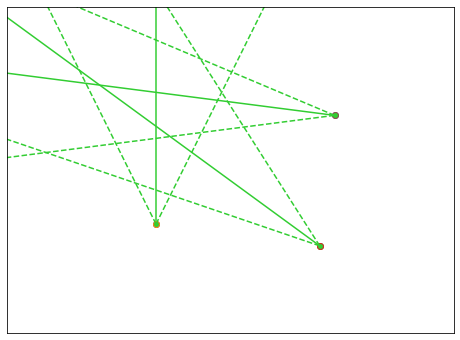

In [4]:
# now with error
# first plot, just the lines:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(tower_locations.shape[0]):
    r = 4
    ax.plot(tower_locations[i, 0], tower_locations[i, 1], "o", mfc="limegreen")
    ax.plot(
        [tower_locations[i, 0], tower_locations[i, 0] +
            np.sin(observed_angles[i]) * r],
        [tower_locations[i, 1], tower_locations[i, 1] +
            np.cos(observed_angles[i]) * r],
        "-",
        color="limegreen",
    )

    ax.plot(tower_locations[i, 0], tower_locations[i, 1], "o", mfc="limegreen")

    ax.plot(
        [
            tower_locations[i, 0],
            tower_locations[i, 0] +
            np.sin(observed_angles[i] + 2 * errors[i]) * r,
        ],
        [
            tower_locations[i, 1],
            tower_locations[i, 1] +
            np.cos(observed_angles[i] + 2 * errors[i]) * r,
        ],
        "--",
        color="limegreen",
    )
    ax.plot(
        [
            tower_locations[i, 0],
            tower_locations[i, 0] +
            np.sin(observed_angles[i] - 2 * errors[i]) * r,
        ],
        [
            tower_locations[i, 1],
            tower_locations[i, 1] +
            np.cos(observed_angles[i] - 2 * errors[i]) * r,
        ],
        "--",
        color="limegreen",
    )


xc = np.linspace(-1, 2, 500)
yc = np.linspace(-1, 2, 500)
ax.set_xlim([xc[0], xc[-1]])
ax.set_ylim([yc[0], yc[-1]])
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    labelleft=False,
    labelbottom=False,
)

In [5]:
def MakePlot(angle_1, angle_2, angle_3, errors_1, errors_2, errors_3):

    # recast
    observed_angles = (
        np.array([angle_1, angle_2, angle_3])[:, np.newaxis, np.newaxis]
        * (2 * np.pi)
        / 360
    )  # in radians
    errors = (
        np.array([errors_1, errors_2, errors_3])[:, np.newaxis, np.newaxis]
        * (2 * np.pi)
        / 360
    )

    # ij tower i, dimension j
    tower_locations = np.array([[0, 0], [1.1, -0.2], [1.2, 1]])
    angles = np.array([180, 90])
    xc = np.linspace(-1, 2, 500)
    yc = np.linspace(-1, 2, 500)
    x = np.array(np.meshgrid(xc, yc))  # shape: coord, xpixel, ypixel

    xs = np.einsum(
        "ijkl->lijk", x[:, :, :, np.newaxis]
    )  # now shape: ~,coord, xpixel, ypixel
    diff = xs - tower_locations[:, :, np.newaxis, np.newaxis]
    dist = np.sqrt(
        np.einsum(
            "ijkl->ikl", (xs -
                          tower_locations[:, :, np.newaxis, np.newaxis]) ** 2
        )
    )
    angles = np.arctan2(
        diff[:, 0, :, :], diff[:, 1, :, :]
    )  # angles to each tower, for all pixels

    log_likelihood = np.einsum(
        "ijk->jk",
        -0.5 * (observed_angles - angles) ** 2 / errors ** 2
        - 0.5 * np.log(2 * np.pi * errors ** 2),
    )

    posterior = np.exp(log_likelihood) / np.sum(np.exp(log_likelihood.ravel()))

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    h = ax.imshow(
        posterior, origin="lower", extent=[xc[0], xc[-1], yc[0], yc[-1]], cmap="Greens"
    )
    # h = ax.contourf(
    #     posterior, origin="lower", extent=[xc[0], xc[-1], yc[0], yc[-1]], cmap="Greens"
    # )

    for i in range(tower_locations.shape[0]):
        r = 4
        ax.plot(tower_locations[i, 0],
                tower_locations[i, 1], "o", mfc="limegreen")
        ax.plot(
            [
                tower_locations[i, 0],
                tower_locations[i, 0] + np.sin(observed_angles[i]) * r,
            ],
            [
                tower_locations[i, 1],
                tower_locations[i, 1] + np.cos(observed_angles[i]) * r,
            ],
            "-",
            color="limegreen",
        )

    (xi, yi) = np.unravel_index(np.argmax(log_likelihood), log_likelihood.shape)
    (xml, yml) = x[:, xi, yi]
    ax.plot(xml, yml, "or")
    ax.set_xlim([xc[0], xc[-1]])
    ax.set_ylim([yc[0], yc[-1]])
    plt.axis("off")

In [10]:
# MakePlot(0,-45,-90,10,20,30)

In [11]:
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive

interact(
    MakePlot,
    angle_1=widgets.IntSlider(min=-20, max=20, step=1, value=0),
    angle_2=widgets.IntSlider(min=-60, max=-20, step=1, value=-45),
    angle_3=widgets.IntSlider(min=-120, max=-45, step=1, value=-80),
    errors_1=widgets.IntSlider(min=1, max=40, step=1, value=10),
    errors_2=widgets.IntSlider(min=1, max=40, step=1, value=10),
    errors_3=widgets.IntSlider(min=1, max=40, step=1, value=10),
);

interactive(children=(IntSlider(value=0, description='angle_1', max=20, min=-20), IntSlider(value=-45, descrip…